In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output

from OOPAO.calibration.compute_KL_modal_basis import compute_M2C, compute_KL_basis

from trwfs.tools.PWFS_CMOS_NOISE_PROOF_may2022_tools import *
from tqdm import trange
from OOPAO.TR_Pyramid import TR_Pyramid
from pypet import Environment, cartesian_product
from trwfs.parameter_files.parameterFile_TR_PWFS_closed_loop import initializeParameterFile
from OOPAO.tools.displayTools           import displayMap

param = initializeParameterFile()

# %% -----------------------     TELESCOPE   ----------------------------------

# create the Telescope object
tel = Telescope(resolution=param['resolution'], \
                diameter=param['diameter'], \
                samplingTime=param['samplingTime'], \
                centralObstruction=param['centralObstruction'])

# %% -----------------------     NGS   ----------------------------------
# create the Source object
ngs = Source(optBand=param['opticalBand'], \
             magnitude=1.0)

# combine the NGS to the telescope using '*' operator:
ngs * tel

tel.computePSF(zeroPaddingFactor=6)

# %% -----------------------     ATMOSPHERE   ----------------------------------

# create the Atmosphere object
atm = Atmosphere(telescope=tel, \
                 r0=param['r0'], \
                 L0=param['L0'], \
                 windSpeed=param['windSpeed'], \
                 fractionalR0=param['fractionnalR0'], \
                 windDirection=param['windDirection'], \
                 altitude=param['altitude'])

# initialize atmosphere
atm.initializeAtmosphere(tel)
#
# self.atm.update()
#
# self.tel + self.atm
# self.tel.computePSF(8)

# %% -----------------------     DEFORMABLE MIRROR   ----------------------------------
# mis-registrations object
misReg = MisRegistration(param)
# if no coordonates specified, create a cartesian dm

dm = DeformableMirror(telescope=tel, \
                      nSubap=param['nSubaperture'], \
                      mechCoupling=param['mechanicalCoupling'], \
                      misReg=misReg)


M2C_KL = compute_M2C(telescope            = tel, \
                     atmosphere         = atm, \
                     deformableMirror   = dm, \
                     param              = None, \
                     nameFolder         = None, \
                     nameFile           = None, \
                     remove_piston      = True, \
                     HHtName            = None, \
                     baseName           = None , \
                     mem_available      = 1e9, \
                     minimF             = False, \
                     nmo                = None, \
                     ortho_spm          = True, \
                     SZ                 = np.int64(2*tel.OPD.shape[0]), \
                     nZer               = 3, \
                     NDIVL              = 1, \
                     recompute_cov=True, \
                     save_output= False)


wfs = TR_Pyramid(nSubap=param['nSubaperture'], \
                 telescope=tel, \
                 modulation=param['modulation'], \
                 lightRatio=param['lightThreshold'], \
                 n_pix_separation=4,
                 calibModulation=param['calibrationModulation'], \
                 psfCentering=param['psfCentering'], \
                 n_pix_edge=2,
                 extraModulationFactor=param['extraModulationFactor'], \
                 postProcessing=param['postProcessing'],
                 nTheta_user_defined = param['nTheta_user_defined'])



# wfs_unmod = TR_Pyramid(nSubap=param['nSubaperture'], \
#                  telescope=tel, \
#                  modulation=0, \
#                  lightRatio=param['lightThreshold'], \
#                  n_pix_separation=4,
#                  calibModulation=param['calibrationModulation'], \
#                  psfCentering=param['psfCentering'], \
#                  n_pix_edge=2,
#                  extraModulationFactor=param['extraModulationFactor'], \
#                  postProcessing=param['postProcessing'],
#                  nTheta_user_defined = param['nTheta_user_defined'])



     °          *      *      
 ▄██▄   ▄██▄  ▄███▄   ▄██▄ * ▄██▄ 
██* ██ ██  ██ ██  ██ ██  ██ ██  ██
██  ██ ██° ██ ██  ██ ██* ██ ██  ██
██  ██ ██  ██ ████▀  ██▄▄██ ██  ██
██* ██ ██  ██ ██     ██▀▀██ ██  ██
██  ██ ██  ██ ██ *   ██  ██ ██* ██
 ▀██▀   ▀██▀  ██   ° ██  ██  ▀██▀ 
      *         *             


Reading/Writting calibration data from data_calibration/
Writting output data in data_cl/
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% TELESCOPE %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
     Diameter             8                [m]        
    Resolution           120             [pixels]     
    Pixel Size           0.07              [m]        
     Surface             50.0              [m2]       
Central Obstruction        0          [% of diameter]  
Pixels in the pupil      11304            [pixels]     
      Source             None                         
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
No light propagated through the telescope
%%%%%%%%%%%%%%%%%%%%%%%%

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


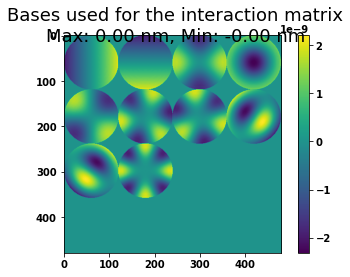

In [2]:
dm.coefs = M2C_KL[:, 0:10] * 1e-9
tel * dm * wfs
displayMap(tel.OPD)

Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!


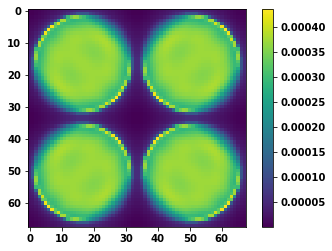

In [3]:
dm.coefs = 0
wfs.modulation = param["modulation"]
tel * dm * wfs
im = plt.imshow(wfs.referenceSignal_2D)
im1_cbar = plt.colorbar(im)

Telescope and Atmosphere separated!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!


Text(0.5, 0, 'KL mode')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


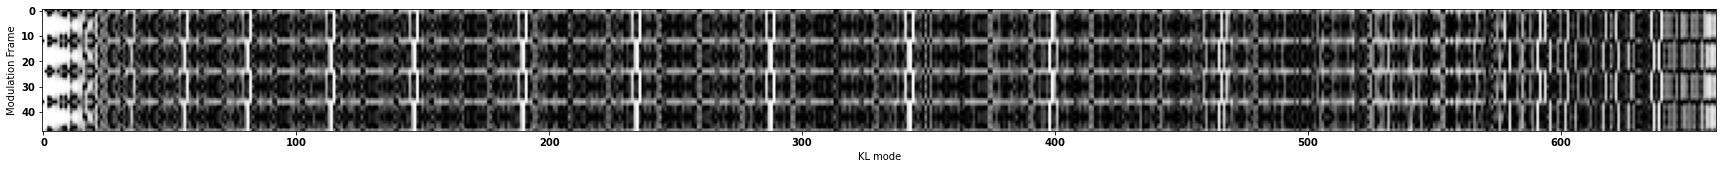

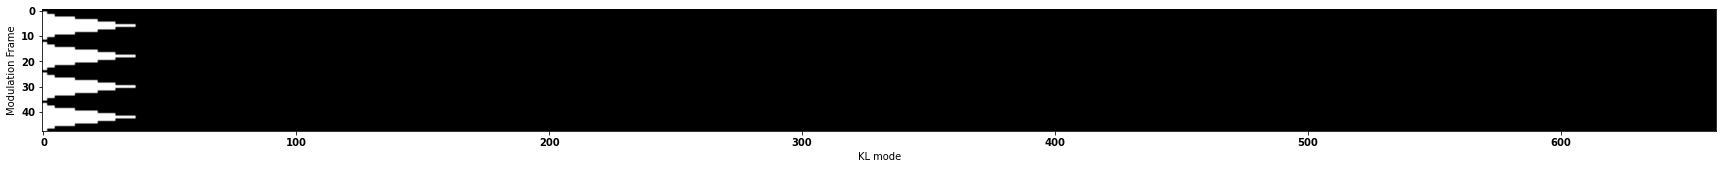

In [4]:
import matplotlib.cm as cm

tel - atm
wfs.cam.photonNoise = False
nModes = M2C_KL.shape[1]
stroke = 1*1e-9

i_cube = np.zeros((wfs.nTheta, np.sum(wfs.validSignal), nModes))
# ngs.nPhoton = 10000000000
wfs.modulation = param['modulation']
dm.coefs = 0
ngs* tel * dm * wfs
ref_cube = wfs.cam.cube[:, wfs.validSignal]
#ref_cube_c = np.zeros((ref_cube.shape[0], nModes))
#push_cube_c = np.zeros((ref_cube.shape[0], nModes))
#pull_cube_c = np.zeros((ref_cube.shape[0], nModes))
#to_cov = np.zeros(())
# bases = generateBases(nModes, tel.resolution, baseType="KL", display=False, scale=False)
for i in range(nModes):

    #t = np.sqrt(np.mean((ref_cube/np.sum(ref_cube))**2, axis=1))
    #ref_cube_c[:,i] = np.sqrt(np.mean((ref_cube/np.sum(ref_cube))**2, axis=1))/stroke
    dm.coefs = M2C_KL[:, i] * stroke
    tel * dm * wfs
    push = wfs.cam.cube[:, wfs.validSignal]
    push_signal = push/np.sum(push) - \
                      ref_cube/np.sum(ref_cube)

    #push_cube_c[:,i] = np.sqrt(np.mean((push/np.sum(push))**2, axis=1))/stroke
    if i == 0:
        push_cube_c = np.mean(push_signal, axis=1)/stroke

    dm.coefs = -M2C_KL[:, i] * stroke
    tel * dm * wfs
    pull = wfs.cam.cube[:, wfs.validSignal]
    pull_signal = pull/np.sum(pull) - \
                      ref_cube/np.sum(ref_cube)
    if i == 0:
        pull_cube_c = np.mean(pull_signal, axis=1)/stroke

    i_cube[:,:,i] = (0.5 * (push_signal - pull_signal) / stroke)



weighting_cube = np.zeros((wfs.nTheta, nModes))
for i in range(nModes):
    #weighting_cube[:,i] = (np.std(i_cube[:, :, i], axis=1))
    avg_val = np.mean(i_cube[:, :, i])
    #avg_val = 0
    weighting_cube[:,i] = ((np.mean((i_cube[:, :, i]-avg_val)**2, axis=1)))**2
    #weighting_cube[:,i] = -(weighting_cube[:,i] - np.mean(weighting_cube[:,i]))
    weighting_cube[:,i] = weighting_cube[:,i]  / np.max(np.abs(weighting_cube[:,i]))

    #weighting_cube[:,i] = np.arctan(weighting_cube[:,i])

plt.figure(figsize=(30,20))
im1 = plt.imshow(weighting_cube, cmap=cm.Greys)
#im1_cbar = plt.colorbar(im)
plt.ylabel("Modulation Frame")
plt.xlabel("KL mode")



framesRemPerFace = [11, 11, 9, 9, 9, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                                      3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1]
binary_weight_cube = np.ones((wfs.nTheta, nModes))
for f in range(len(framesRemPerFace)):
    idx = calcEquidistantFrameIndices(framesRemPerFace[f], wfs.nTheta)
    binary_weight_cube[idx, f] = 0

plt.figure(figsize=(30,20))
im2 = plt.imshow(binary_weight_cube, cmap=cm.Greys)
#im1_cbar = plt.colorbar(im)
plt.ylabel("Modulation Frame")
plt.xlabel("KL mode")

In [ ]:
import matplotlib.cm as cm

tel - atm
wfs.cam.photonNoise = False
nModes = M2C_KL.shape[1]
stroke = 1*1e-9


def getInterationMatrixModulated(weights, mod=5):
    imat = np.zeros((np.sum(wfs.validSignal), nModes))
    wfs.modulation = mod
    dm.coefs = 0
    tel * dm * wfs
    ref_cube = wfs.cam.cube[:, wfs.validSignal]

    for m in range(nModes):
        dm.coefs = M2C_KL[:, m] * stroke
        tel * dm * wfs

        push = wfs.cam.cube[:, wfs.validSignal]
        push_signal = np.sum(push*weights[:, np.newaxis, m], axis=0)/np.sum(push*weights[:, np.newaxis, m]) - \
                      np.sum(ref_cube*weights[:, np.newaxis, m], axis=0)/np.sum(ref_cube*weights[:, np.newaxis, m])


        dm.coefs = -M2C_KL[:, m] * stroke
        tel * dm * wfs

        pull = wfs.cam.cube[:, wfs.validSignal]
        pull_signal = np.sum(pull*weights[:, np.newaxis, m], axis=0)/np.sum(pull*weights[:, np.newaxis, m]) - \
                      np.sum(ref_cube*weights[:, np.newaxis, m], axis=0)/np.sum(ref_cube*weights[:, np.newaxis, m])

        imat[:,m] = (0.5 * (push_signal - pull_signal) / stroke)
        #imat[:,m] /=np.std(imat[:,m] )
    return imat

def getInterationMatrixUnmodulated():
    imat = np.zeros((np.sum(wfs.validSignal), nModes))
    wfs.modulation = 0
    dm.coefs = 0
    tel * dm * wfs
    ref_frame = wfs.cam.frame[wfs.validSignal]

    for m in range(nModes):
        dm.coefs = M2C_KL[:, m] * stroke
        tel * dm * wfs

        push = wfs.cam.frame[wfs.validSignal]
        push_signal = push/np.sum(push) - \
                      ref_frame/np.sum(ref_frame)



        dm.coefs = -M2C_KL[:, m] * stroke
        tel * dm * wfs

        pull = wfs.cam.frame[wfs.validSignal]
        pull_signal = pull/np.sum(pull) - \
                      ref_frame/np.sum(ref_frame)


        imat[:,m] = (0.5 * (push_signal - pull_signal) / stroke)
        #imat[:,m] /=np.std(imat[:,m] )

    return imat

I_mat_modulated = getInterationMatrixModulated(np.ones((wfs.nTheta, nModes)), mod=param['modulation'])
I_mat_unmodulated = getInterationMatrixUnmodulated()
I_mat_weighted = getInterationMatrixModulated(weighting_cube, mod=param['modulation'])
I_mat_binary = getInterationMatrixModulated(binary_weight_cube, mod=param['modulation'])


I_mat_modulated_inv = inv(I_mat_modulated.T @ I_mat_modulated) @ I_mat_modulated.T
I_mat_unmodulated_inv = inv(I_mat_unmodulated.T @ I_mat_unmodulated) @ I_mat_unmodulated.T
I_mat_weighted_inv = inv(I_mat_weighted.T @ I_mat_weighted) @ I_mat_weighted.T
I_mat_binary_inv = inv(I_mat_binary.T @ I_mat_binary) @ I_mat_binary.T


Telescope and Atmosphere separated!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!
Updating the reference slopes and Wavelength Calibration for the new modulation...
Done!


# Finally, with the interaction matrix, we should be able the calculate the sensitivity of the system.
This is the part I struggle with, I am usure why I don't get values between 0 and 2 like in the litterature. Here I'm following formula 3.11 from Chambouleyron's thesis.

$$ s_b (\phi_i) = \| \delta I(\phi_i) \|_2   $$

In [ ]:
radian_in_1m = (2*np.pi)/ ngs.wavelength
plt.figure(figsize=(30,10))
plt.plot(np.sqrt(wfs.nSubap**2) * np.sqrt(np.sum((I_mat_modulated)**2, axis=0)) / radian_in_1m, marker="x",label="Modulated")
plt.plot(np.sqrt(wfs.nSubap**2) * np.sqrt(np.sum((I_mat_unmodulated - np.mean(I_mat_modulated, axis=0) )**2, axis=0)) / radian_in_1m, marker="o",label="Unmodulated")
plt.plot(np.sqrt(wfs.nSubap**2) * np.sqrt(np.sum((I_mat_weighted )**2, axis=0)) / radian_in_1m, marker="o", label="TR WFS - Weighted")
plt.plot(np.sqrt(wfs.nSubap**2) * np.sqrt(np.sum((I_mat_binary )**2, axis=0)) / radian_in_1m, marker="o", label="TR WFS - Binary")
plt.xlabel("KL modes")
plt.ylabel("Sensitivity (std of interaction matrix)")
plt.title(f"Sensitivity with lambda={param['modulation']}, SubAp={wfs.nSubap}")
plt.legend()

In [ ]:

# These are the calibration data used to close the loop
calib_CL    = I_mat_weighted_inv
M2C_CL      = M2C_KL

wfs.cam.photonNoise = True
param['nLoop'] =500
plt.close('all')

# Define a source with the magnitude we want
ngs = Source(optBand=param['opticalBand'], \
             magnitude=param['magnitude'])

# combine the NGS to the telescope using '*' operator:
ngs * tel

tel.computePSF(zeroPaddingFactor=6)

# combine telescope with atmosphere
tel+atm

# initialize DM commands
dm.coefs=0
ngs*tel*dm*wfs

plt.ion()
# setup the display
fig         = plt.figure(79, figsize=(15,10))
ax1         = plt.subplot(2,3,1)
im_atm      = ax1.imshow(tel.src.phase)
plt.colorbar(im_atm)
plt.title('Turbulence phase [rad]')

ax2         = plt.subplot(2,3,2)
im_dm       = ax2.imshow(dm.OPD*tel.pupil)
plt.colorbar(im_dm)
plt.title('DM phase [rad]')
tel.computePSF(zeroPaddingFactor=6)

ax4         = plt.subplot(2,3,3)
im_PSF_OL   = ax4.imshow(tel.PSF)
plt.colorbar(im_PSF_OL)
plt.title('OL PSF')


ax3         = plt.subplot(2,3,5)
im_residual = ax3.imshow(tel.src.phase)
plt.colorbar(im_residual)
plt.title('Residual phase [rad]')

ax5         = plt.subplot(2,3,4)
im_wfs_CL   = ax5.imshow(wfs.cam.frame)
plt.colorbar(im_wfs_CL)
plt.title('Pyramid Frame CL')

ax6         = plt.subplot(2,3,6)
im_PSF      = ax6.imshow(tel.PSF)
plt.colorbar(im_PSF)
plt.title('CL PSF')

plt.show()

# allocate memory to save data
SR                      = np.zeros(param['nLoop'])
total                   = np.zeros(param['nLoop'])
residual                = np.zeros(param['nLoop'])
#wfsSignal               = np.arange(0,wfs.nSignal)*0
wfsSignal = np.zeros(wfs.pyramidSignalCube.shape)
a_est = np.zeros((M2C_CL.shape[1]))
# loop parameters
gainCL                  = 0.4
wfs.cam.photonNoise     = True
update_figures          = True

for i in range(param['nLoop']):
    a=time.time()
    # update phase screens => overwrite tel.OPD and consequently tel.src.phase
    atm.update()
     # save phase variance
    total[i]=np.std(tel.OPD[np.where(tel.pupil>0)])*1e9
     # save turbulent phase
    turbPhase = tel.src.phase
    if update_figures == True:
           # compute the OL PSF and update the display
       tel.computePSF(zeroPaddingFactor=6)
       im_PSF_OL.set_data(np.log(tel.PSF/tel.PSF.max()))
       im_PSF_OL.set_clim(vmin=-3,vmax=0)

     # propagate to the WFS with the CL commands applied
    tel*dm*wfs

     # save the DM OPD shape
    dmOPD=tel.pupil*dm.OPD*2*np.pi/ngs.wavelength
    
    
    # for j_mode in range(len(a_est)):
    #     t_signal = wfs.cam.cube[:, wfs.validSignal]
    #     t_t_signal = np.sum(t_signal*weighting_cube[:, np.newaxis, j_mode], axis=0)/np.sum(t_signal*weighting_cube[:, np.newaxis, j_mode]) - \
    #                   np.sum(ref_cube*weighting_cube[:, np.newaxis, j_mode], axis=0)/np.sum(ref_cube*weighting_cube[:, np.newaxis, j_mode])
    #     #weighted_signal = wfsSignal * self.weightsPerFramePerMode[j_mode, :, np.newaxis]
    #     a_est[j_mode] = ( calib_CL @ t_t_signal)[j_mode]

    t_signal = wfs.cam.cube[:, wfs.validSignal]
    t_t_signal = (t_signal.T @ weighting_cube[:,  :]) / np.sum(t_signal.T @ weighting_cube[:, :], axis=0) - \
                 (ref_cube.T @ weighting_cube[:, :]) / np.sum(ref_cube.T @ weighting_cube[:, :], axis=0)
    a_est = np.diag(calib_CL @ t_t_signal)

    correction = np.matmul(M2C_CL, a_est)
    
    dm.coefs=dm.coefs - gainCL*correction
     # store the slopes after computing the commands => 2 frames delay
    wfsSignal = wfs.pyramidSignalCube
    b= time.time()
    #print('Elapsed time: ' + str(b-a) +' s')
    # update displays if required
    if update_figures==True:

       # Turbulence
       im_atm.set_data(turbPhase)
       im_atm.set_clim(vmin=turbPhase.min(),vmax=turbPhase.max())
       # WFS frame
       C=wfs.cam.frame
       im_wfs_CL.set_data(C)
       im_wfs_CL.set_clim(vmin=C.min(),vmax=C.max())
       # DM OPD
       im_dm.set_data(dmOPD)
       im_dm.set_clim(vmin=dmOPD.min(),vmax=dmOPD.max())

       # residual phase
       D=tel.src.phase
       D=D-np.mean(D[tel.pupil])
       im_residual.set_data(D)
       im_residual.set_clim(vmin=D.min(),vmax=D.max())

       tel.computePSF(zeroPaddingFactor=6)
       data = np.log(tel.PSF/tel.PSF.max())
       im_PSF.set_data(data)
       im_PSF.set_clim(vmin=-4,vmax=0)
       # Zoom automatically on the PSF
       bound = np.argwhere(data>=(-4))
       ax6.set_xlim(min(bound[:, 1]), max(bound[:, 1]))
       ax6.set_ylim(min(bound[:, 0]), max(bound[:, 0]))

       #plt.draw()
       #plt.show()
       clear_output(wait = True)
       display(fig)
       plt.pause(0.001)


    SR[i]=np.exp(-np.var(tel.src.phase[np.where(tel.pupil==1)]))
    residual[i]=np.std(tel.OPD[np.where(tel.pupil>0)])*1e9
    OPD=tel.OPD[np.where(tel.pupil>0)]

# Print the final stats
print('Loop'+str(i)+'/'+str(param['nLoop'])+' Turbulence: '+str(total[i])+' -- Residual:' +str(residual[i])+ '\n')


In [ ]:
plt.figure()
plt.plot(total)
plt.plot(residual)
plt.xlabel('Time [ms]')
plt.ylabel('WFE [nm]')

plt.pause(10)


In [ ]:
# recreate the Atmosphere object, to reset the atmosphere to the same starting point
atm = Atmosphere(telescope=tel, \
                 r0=param['r0'], \
                 L0=param['L0'], \
                 windSpeed=param['windSpeed'], \
                 fractionalR0=param['fractionnalR0'], \
                 windDirection=param['windDirection'], \
                 altitude=param['altitude'])

# initialize atmosphere
atm.initializeAtmosphere(tel)

In [ ]:

# These are the calibration data used to close the loop
calib_CL    = I_mat_modulated_inv
M2C_CL      = M2C_KL

wfs.cam.photonNoise = True
param['nLoop'] =500
plt.close('all')

# combine telescope with atmosphere
tel+atm

# initialize DM commands
dm.coefs=0
ngs*tel*dm*wfs

plt.ion()
# setup the display
fig         = plt.figure(79, figsize=(15,10))
ax1         = plt.subplot(2,3,1)
im_atm      = ax1.imshow(tel.src.phase)
plt.colorbar(im_atm)
plt.title('Turbulence phase [rad]')

ax2         = plt.subplot(2,3,2)
im_dm       = ax2.imshow(dm.OPD*tel.pupil)
plt.colorbar(im_dm)
plt.title('DM phase [rad]')
tel.computePSF(zeroPaddingFactor=6)

ax4         = plt.subplot(2,3,3)
im_PSF_OL   = ax4.imshow(tel.PSF)
plt.colorbar(im_PSF_OL)
plt.title('OL PSF')


ax3         = plt.subplot(2,3,5)
im_residual = ax3.imshow(tel.src.phase)
plt.colorbar(im_residual)
plt.title('Residual phase [rad]')

ax5         = plt.subplot(2,3,4)
im_wfs_CL   = ax5.imshow(wfs.cam.frame)
plt.colorbar(im_wfs_CL)
plt.title('Pyramid Frame CL')

ax6         = plt.subplot(2,3,6)
im_PSF      = ax6.imshow(tel.PSF)
plt.colorbar(im_PSF)
plt.title('CL PSF')

plt.show()

# allocate memory to save data
SR                      = np.zeros(param['nLoop'])
total                   = np.zeros(param['nLoop'])
residual                = np.zeros(param['nLoop'])
wfsSignal               = np.arange(0,wfs.nSignal)*0

# loop parameters
gainCL                  = 0.4
wfs.cam.photonNoise     = True
update_figures          = True

for i in range(param['nLoop']):
    a=time.time()
    # update phase screens => overwrite tel.OPD and consequently tel.src.phase
    atm.update()
     # save phase variance
    total[i]=np.std(tel.OPD[np.where(tel.pupil>0)])*1e9
     # save turbulent phase
    turbPhase = tel.src.phase
    if update_figures == True:
           # compute the OL PSF and update the display
       tel.computePSF(zeroPaddingFactor=6)
       im_PSF_OL.set_data(np.log(tel.PSF/tel.PSF.max()))
       im_PSF_OL.set_clim(vmin=-3,vmax=0)

     # propagate to the WFS with the CL commands applied
    tel*dm*wfs

     # save the DM OPD shape
    dmOPD=tel.pupil*dm.OPD*2*np.pi/ngs.wavelength

    dm.coefs=dm.coefs-gainCL*M2C_CL@calib_CL@wfsSignal
     # store the slopes after computing the commands => 2 frames delay
    wfsSignal=wfs.pyramidSignal
    b= time.time()
    #print('Elapsed time: ' + str(b-a) +' s')
    # update displays if required
    if update_figures==True:

       # Turbulence
       im_atm.set_data(turbPhase)
       im_atm.set_clim(vmin=turbPhase.min(),vmax=turbPhase.max())
       # WFS frame
       C=wfs.cam.frame
       im_wfs_CL.set_data(C)
       im_wfs_CL.set_clim(vmin=C.min(),vmax=C.max())
       # DM OPD
       im_dm.set_data(dmOPD)
       im_dm.set_clim(vmin=dmOPD.min(),vmax=dmOPD.max())

       # residual phase
       D=tel.src.phase
       D=D-np.mean(D[tel.pupil])
       im_residual.set_data(D)
       im_residual.set_clim(vmin=D.min(),vmax=D.max())

       tel.computePSF(zeroPaddingFactor=6)
       data = np.log(tel.PSF/tel.PSF.max())
       im_PSF.set_data(data)
       im_PSF.set_clim(vmin=-4,vmax=0)
       # Zoom automatically on the PSF
       bound = np.argwhere(data>=(-4))
       ax6.set_xlim(min(bound[:, 1]), max(bound[:, 1]))
       ax6.set_ylim(min(bound[:, 0]), max(bound[:, 0]))

       #plt.draw()
       #plt.show()
       clear_output(wait = True)
       display(fig)
       plt.pause(0.001)


    SR[i]=np.exp(-np.var(tel.src.phase[np.where(tel.pupil==1)]))
    residual[i]=np.std(tel.OPD[np.where(tel.pupil>0)])*1e9
    OPD=tel.OPD[np.where(tel.pupil>0)]

#Print the final stats
print('Loop'+str(i)+'/'+str(param['nLoop'])+' Turbulence: '+str(total[i])+' -- Residual:' +str(residual[i])+ '\n')


In [ ]:
plt.figure()
plt.plot(total)
plt.plot(residual)
plt.xlabel('Time [ms]')
plt.ylabel('WFE [nm]')

plt.pause(10)
